In [1]:
import os
os.chdir("utils")

In [2]:
# Initialization
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

raw_tr = pd.read_csv("../data/train.csv.zip")
raw_tr = raw_tr.replace(to_replace=-999, value=np.nan)

raw_te = pd.read_csv("../data/test.csv.zip")
raw_te = raw_te.replace(to_replace=-999, value=np.nan)

In [3]:
# Explore NaNs
nans = raw_tr.isnull() 
nan_cols = nans.sum(axis=0) / raw_tr.shape[0]
nan_rows = nans.sum(axis=1)

with pd.option_context('display.float_format','{:.4%}'.format):
     print("NaN column summary:\n{}\n".format(nan_cols[nan_cols > 0]))
     print("NaN row summary:\n{}".format(nan_rows[nan_rows > 0]))
     
print("\nShapes")
print("\traw: {}".format(raw_tr.shape))
print("\tdrop rows: {}".format(raw_tr.dropna(axis=0).shape))
print("\tdrop cols: {}".format(raw_tr.dropna(axis=1).shape))

NaN column summary:
DER_mass_MMC             15.2456%
DER_deltaeta_jet_jet     70.9828%
DER_mass_jet_jet         70.9828%
DER_prodeta_jet_jet      70.9828%
DER_lep_eta_centrality   70.9828%
PRI_jet_leading_pt       39.9652%
PRI_jet_leading_eta      39.9652%
PRI_jet_leading_phi      39.9652%
PRI_jet_subleading_pt    70.9828%
PRI_jet_subleading_eta   70.9828%
PRI_jet_subleading_phi   70.9828%
dtype: float64

NaN row summary:
1          7
2          8
3         10
4         10
7          7
          ..
249995    11
249996    11
249997     7
249998    10
249999    11
Length: 181886, dtype: int64

Shapes
	raw: (250000, 32)
	drop rows: (68114, 32)
	drop cols: (250000, 21)


In [4]:
################################################################################
# Prepare data and labels
################################################################################

# Drop rows with NaNs
#data = raw.dropna(axis=0)

# Drop columns with NaNs
#data = raw.dropna(axis=1)

# Replace NaNs with mean of the column
#means = raw_tr.means()
#train = raw_tr.fillna(means)
#test = raw_te.fillna(means)

# Signal = 1, Background = 0
train = raw_tr.replace({'s':1,'b':0})
test = raw_te.replace({'s':1,'b':0})

# Split data and labels
X = train.drop(columns=['Id','Prediction'])
y = train['Prediction']

# Standarize data
from helpers import standardize
X, mean, std = standardize(X)

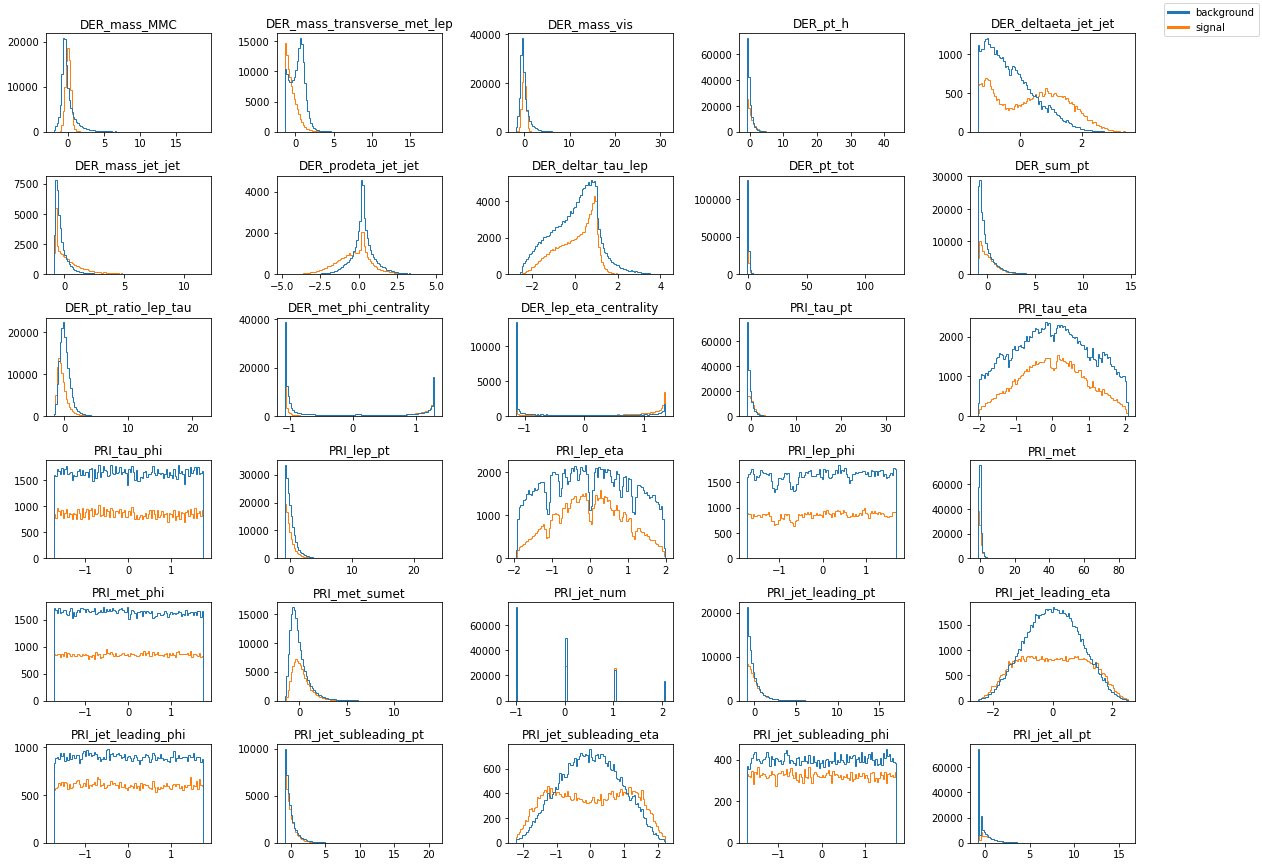

In [5]:
from matplotlib.lines import Line2D
def plot_histogram(y, X):
    mask = (y == 0)
    labels = ("background","signal")
    n = X.shape[1]

    nrows = (n+4)//5
    ncols = 5

    fig, axs = plt.subplots(nrows, ncols, figsize=(16,12))

    for k, name in enumerate(X):
        row = k // ncols
        col = k % ncols
        axs[row, col].hist([X[name][mask], X[name][~mask]], 
                 label=labels, 
                 bins=100, 
                 histtype='step');
        axs[row, col].set_title(name)
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color'][:2]
    lines = [Line2D([0], [0], color=c, linewidth=3, linestyle='-') for c in colors]
    fig.legend(lines, labels, bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0.)
    fig.tight_layout()

plot_histogram(y, X)

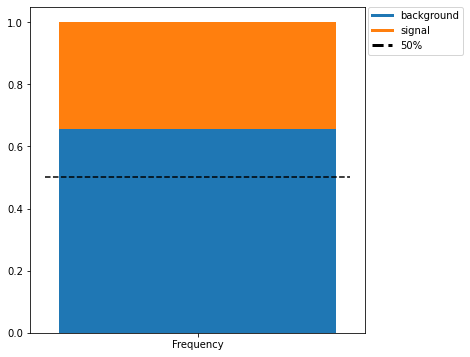

In [6]:
def plot_bar_counts(y, X):
    width = 0.5
    idx = (1,)
    labels = ("background","signal","50%")

    vals, counts = np.unique(y, return_counts=True)
    assert (len(vals) == 2)

    b = counts[vals == 0] / y.shape[0]
    s = counts[vals == 1] / y.shape[0]

    plt.figure(figsize=(6,6))
    plt.bar(idx, b, width)
    plt.bar(idx, s, width, bottom=b)
    plt.xticks(idx, ('Frequency',))
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color'][:2]
    lines = [Line2D([0], [0], color=c, linewidth=3, linestyle='-') for c in colors]

    left, right = plt.xlim()
    plt.hlines(0.5, left, right, linestyle='--')
    colors.append('black')
    lines.append(Line2D([0], [0], color='black', linewidth=3, linestyle='--'))

    plt.legend(lines, labels, bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0.)

plot_bar_counts(y, X)

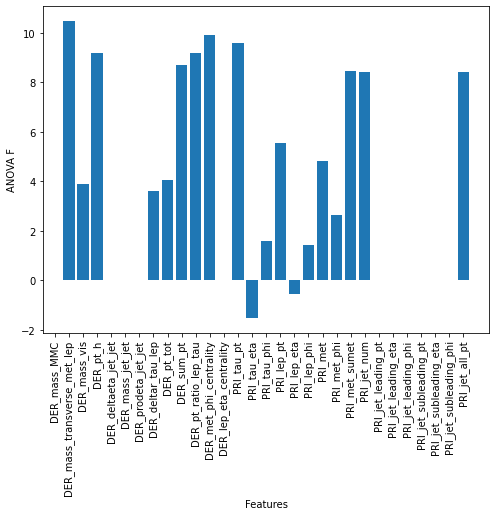

In [7]:
from scipy import stats

# ANOVA:
#  - https://dzone.com/articles/correlation-between-categorical-and-continuous-var-1

corr = np.empty(train.shape[1]-2)
cols = [col for col in train.drop(columns=['Id','Prediction'])]
    
for j, col in enumerate(cols):
    F, p = stats.f_oneway(train[train['Prediction']==0][col],
                              train[train['Prediction']==1][col])
    corr[j] = F

idx = np.arange(corr.shape[0])
plt.figure(figsize=(8,6))
plt.bar(idx, np.log(corr))
plt.xticks(idx, cols, rotation=90)
plt.xlabel('Features')
plt.ylabel('ANOVA F')
plt.show()

## Prepare Features



In [8]:
def build_poly(x, degree):
    """polynomial basis functions for each column of x, for j=1 up to j=degree, and single constant term."""
    if (degree < 0): raise ValueError("degree must be positive")
    
    phi = np.empty((x.shape[0], x.shape[1]*degree+1))
    
    # Constant term
    phi[:,-1] = 1
    
    # Higher order terms
    for j in range(x.shape[1]):
        phi[:,j*degree] = x[:,j]
        for d in range(1,degree):
            col = j*degree+d
            phi[:,col] = phi[:,col-1] * x[:,j]
    
    return phi

def standardize_numpy(x):
    """Standardize the original data set. Works on numpy arrays."""
    mean_x = x.mean(axis=0, keepdims=True)
    x = x - mean_x
    std_x = x.std(axis=0, keepdims=True)
    x = x / std_x
    return x, mean_x, std_x

def prepare_feautres(tx_nan, degree, mean=None): 
    # Get column means, if necessary
    if mean is None:
        mean = np.nanmean(tx_nan,axis=0)
    
    # Replace NaNs
    tx_val = np.where(np.isnan(tx_nan), mean, tx_nan)
    
    # Polynomial features
    tx = build_poly(tx_val, degree)
    const_col = tx.shape[1]-1
    
    # Add NaN indicator columns
    nan_cols = np.flatnonzero(np.any(np.isnan(tx_nan), axis=0))

    ind_cols = np.empty((tx_nan.shape[0], nan_cols.shape[0]))
    ind_cols = np.where(np.isnan(tx_nan[:,nan_cols]), 1, 0)

    tx = np.c_[tx, ind_cols]
    
    # Standardize
    tx, _, _ = standardize_numpy(tx)
    tx[:,const_col] = 1.0
    
    return tx, mean, nan_cols

## Hyper-Parameter Selection



In [9]:
def build_k_indices(y, k_fold, seed):
    """build k indices for k-fold."""
    num_row = y.shape[0]
    interval = int(num_row / k_fold)
    np.random.seed(seed)
    indices = np.random.permutation(num_row)
    k_indices = [indices[k * interval: (k + 1) * interval]
                 for k in range(k_fold)]
    return np.array(k_indices)

def prepare_split_data(y, tx, degree, k_fold, seed):
    """
    Split the dataset based on k-fold cross validation and prepare features. 
    Returns the k splits.
    """
    k_indices = build_k_indices(y, k_fold, seed)
    
    tx_trs = []
    y_trs = []
    tx_tes = []
    y_tes = []
    
    for k in range(k_fold):
        # get k-th subgroup in test, others in train
        mask = np.full((y.shape[0]), False, dtype=bool)
        mask[k_indices[k]] = True
    
        y_te = y[mask]
        tx_te = tx[mask]
    
        mask = ~mask
        y_tr = y[mask]
        tx_tr = tx[mask]
        
        # Replace NaNs and standarize
        tx_tr, mean, _ = prepare_feautres(tx_tr, degree)
        tx_te, _, _ = prepare_feautres(tx_te, degree, mean)
        
        tx_trs.append(tx_tr)
        y_trs.append(y_tr)
        tx_tes.append(tx_te)
        y_tes.append(y_te)
    
    return y_trs, tx_trs, y_tes, tx_tes

In [10]:
from abc import ABC, abstractmethod

class Classifier(ABC):
    """Metaclass for classifier classes."""

    def __init__(self):
        pass

    @abstractmethod
    def fit(self, y, tx):
        raise NotImplementedError

    @abstractmethod
    def predict(self, w, tx):
        raise NotImplementedError

    @abstractmethod
    def compute_loss(self, y, tx, w):
        raise NotImplementedError
    

class RegularizedLogisticRegression(Classifier):
    """Implementation of regularized logistic regression."""

    def __init__(self, gamma, lambda_, reg):
        self.gamma = gamma
        self.lambda_ = lambda_
        self.reg = reg

    def fit(self, y, tx):
        return self.__reg_logistic_regression(y, tx)

    def predict(self, w, oos):
        return np.rint(sigmoid(oos @ w))

    def __reg_logistic_regression(self, y, tx):

        return reg_logistic_regression(
            y=y,
            tx=tx,
            lambda_=self.lambda_,
            reg=self.reg,
            initial_w=np.zeros((tx.shape[1])),
            max_iters=30,
            gamma=self.gamma,
            batch_size=1  
        )

    def compute_loss(self, y, tx, w):
        
        return reg_logistic_error(
            y=y,
            tx=tx,
            w=w,
            lambda_=self.lambda_,
            reg=self.reg
        )

In [11]:
from implementations import reg_logistic_regression
from costs import reg_logistic_error
from helpers import sigmoid
from cross_validation import *

def cross_validation(y_tr, tx_tr, y_te, tx_te, comb, verbose=2):
    # instantiate the the classifier
    clf = RegularizedLogisticRegression(**comb)
    # fit the model
    w, loss = clf.fit(y_tr, tx_tr)
    # calculate the loss for train and test data
    loss_tr = clf.compute_loss(y_tr, tx_tr, w)
    loss_te = clf.compute_loss(y_te, tx_te, w)
    # compute performance metrics
    p = clf.predict(w, tx_te)
    f1 = f1_score(y_te, p)
    acc = accuracy(y_te, p)
        
    return loss_tr, loss_te, f1, acc

In [12]:
import itertools as it

def model_selection(y, tx, k_fold, degree, grid, verbose=2):
    
    max_loss = np.finfo(float).min
    max_acc = np.finfo(float).min

    # Generate total permuations of hps for gridsearch
    k, v = zip(*grid.items())
    permutations = [dict(zip(k, values)) for values in it.product(*v)]
    seeds = range(len(permutations))
    losses = {
        "loss_tr": [],
        "loss_te": [],
        "f1_te": [],
        "acc_te": []
    }
    
    print(f'Training on {int((1-1/k_fold)*y.shape[0])} samples')
    for permutation, seed in zip(permutations, seeds):
        print(f'Seed: {seed}, Permutation: {str(permutation)}')
        y_trs, tx_trs, y_tes, tx_tes = prepare_split_data(y, tx, degree, k_fold, seed)
        # Cross validation
        trl = 0.0
        tel = 0.0
        f1 = 0.0
        acc = 0.0
        for k in range(k_fold):
            tr, te, f1l, accl = cross_validation(
                y_trs[k],
                tx_trs[k],
                y_tes[k],
                tx_tes[k],
                comb=permutation
            )
            trl += tr
            tel += te
            f1 += f1l
            acc += accl

            if verbose > 1:
                print(f'\t\t\tTR={tr:.4e} | TE={te:.4e} | F1:{f1l:.4f} | ACC:{accl:.4f}')
                    
            if ~np.all(np.isfinite((tr, te, f1, acc))): break
            
        losses["loss_tr"].append(trl / k_fold)
        losses["loss_te"].append(tel / k_fold)
        losses["f1_te"].append(f1 / k_fold)
        losses["acc_te"].append(acc / k_fold)
        
    print(f'\nMINIMUMS:')
    print(f'\tBest parameters: {str(permutations[np.argmax(losses["acc_te"])])}')
    print(f'\tAccuracy: {np.max(losses["acc_te"])}')
    print(f'\tF1-score: {np.max(losses["f1_te"])}')
    print(f'\tLoss: {np.min(losses["loss_te"])}')
    
    return permutations[np.argmax(losses["acc_te"])]

In [13]:
grid = {
    "gamma": [0.5, 0.6],
    "lambda_": [0.01, 0.1],
    "reg": [1, 2]
}
# seeds = (42,)
reg = 2 # L2 regularization
k_fold = 4
verbose = 2

degree = 3

tx = np.asarray(train.drop(columns=['Id','Prediction']))
y = np.asarray(train['Prediction'])
params = model_selection(
    y=y,
    tx=tx,
    k_fold=k_fold,
    degree=degree,
    grid=grid,
    verbose=verbose
)

Training on 187500 samples
Seed: 0, Permutation: {'gamma': 0.5, 'lambda_': 0.01, 'reg': 1}


/Users/nathansimonis/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in true_divide


			TR=1.1127e+00 | TE=1.1147e+00 | F1:0.5893 | ACC:0.7557
			TR=1.1256e+00 | TE=1.1173e+00 | F1:0.5866 | ACC:0.7542
			TR=1.1180e+00 | TE=1.1190e+00 | F1:0.5932 | ACC:0.7582
			TR=1.1134e+00 | TE=1.1175e+00 | F1:0.5920 | ACC:0.7566
Seed: 1, Permutation: {'gamma': 0.5, 'lambda_': 0.01, 'reg': 2}
			TR=1.1888e+00 | TE=1.1972e+00 | F1:0.6164 | ACC:0.7637
			TR=1.1940e+00 | TE=1.1909e+00 | F1:0.6088 | ACC:0.7600
			TR=1.1884e+00 | TE=1.1883e+00 | F1:0.6213 | ACC:0.7650
			TR=1.1914e+00 | TE=1.1927e+00 | F1:0.6149 | ACC:0.7622
Seed: 2, Permutation: {'gamma': 0.5, 'lambda_': 0.1, 'reg': 1}


/Users/nathansimonis/Dropbox/Unif/Master 2/EPFL/ML_course/epflml-projects/Project_1/utils/costs.py:67: RuntimeWarning: divide by zero encountered in log
  loss = (- 1 / tx.shape[0]) * np.sum(y * np.log(a) + (1 - y) * (np.log(1 - a)))
/Users/nathansimonis/Dropbox/Unif/Master 2/EPFL/ML_course/epflml-projects/Project_1/utils/costs.py:67: RuntimeWarning: invalid value encountered in multiply
  loss = (- 1 / tx.shape[0]) * np.sum(y * np.log(a) + (1 - y) * (np.log(1 - a)))


			TR=nan | TE=inf | F1:0.4100 | ACC:0.4606
Seed: 3, Permutation: {'gamma': 0.5, 'lambda_': 0.1, 'reg': 2}
			TR=9.3967e-01 | TE=9.4098e-01 | F1:0.6168 | ACC:0.7543
			TR=9.2649e-01 | TE=9.2551e-01 | F1:0.6279 | ACC:0.7569
			TR=9.3802e-01 | TE=9.3867e-01 | F1:0.6143 | ACC:0.7503
			TR=9.3834e-01 | TE=9.3971e-01 | F1:0.6147 | ACC:0.7529
Seed: 4, Permutation: {'gamma': 0.6, 'lambda_': 0.01, 'reg': 1}
			TR=1.1616e+00 | TE=1.1624e+00 | F1:0.5899 | ACC:0.7489
			TR=1.1687e+00 | TE=1.1614e+00 | F1:0.5829 | ACC:0.7428
			TR=1.1568e+00 | TE=1.1605e+00 | F1:0.5881 | ACC:0.7473
			TR=1.1576e+00 | TE=1.1593e+00 | F1:0.5874 | ACC:0.7470
Seed: 5, Permutation: {'gamma': 0.6, 'lambda_': 0.01, 'reg': 2}
			TR=inf | TE=1.2127e+00 | F1:0.6132 | ACC:0.7625
Seed: 6, Permutation: {'gamma': 0.6, 'lambda_': 0.1, 'reg': 1}
			TR=nan | TE=1.3133e+00 | F1:0.3910 | ACC:0.4294
Seed: 7, Permutation: {'gamma': 0.6, 'lambda_': 0.1, 'reg': 2}
			TR=inf | TE=inf | F1:0.5726 | ACC:0.6758

MINIMUMS:
	Best parameters: 

In [14]:
# Save expensive computation
#%store all_loss all_f1 all_acc min_gamma min_lambda
#%store -r all_loss all_f1 all_acc min_gamma min_lambda

#MINIMUMS:
#   lambda=1.0000e-02
#   gamma=5.9948e-01
#   Test loss=1.2879e+00
#   Accuracy=0.7725

## Train



In [15]:
# Prepare training and test data
tx_tr = np.asarray(train.drop(columns=['Id','Prediction']))
y_tr = np.asarray(train['Prediction'])

tx_te = np.asarray(test.drop(columns=['Id','Prediction']))

tx_tr, mean, nan_cols = prepare_feautres(tx_tr, degree)
tx_te, _, _ = prepare_feautres(tx_te, degree, mean)

# Train model
clf = RegularizedLogisticRegression(**params)
w, loss = clf.fit(y_tr, tx_tr)
loss_tr = clf.compute_loss(y_tr, tx_tr, w)
y_pred = clf.predict(w, tx_tr)

# Report results
f1 = f1_score(y_tr, y_pred)
acc = accuracy(y_tr, y_pred)

print('RESULTS:')
print(f'\tLoss:     {loss_tr:.4e}')
print(f'\tF1 score: {f1:.4f}')
print(f'\tAccuracy: {acc:.4f}')

/Users/nathansimonis/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in true_divide


RESULTS:
	Loss:     1.1900e+00
	F1 score: 0.6149
	Accuracy: 0.7624


## Explore result



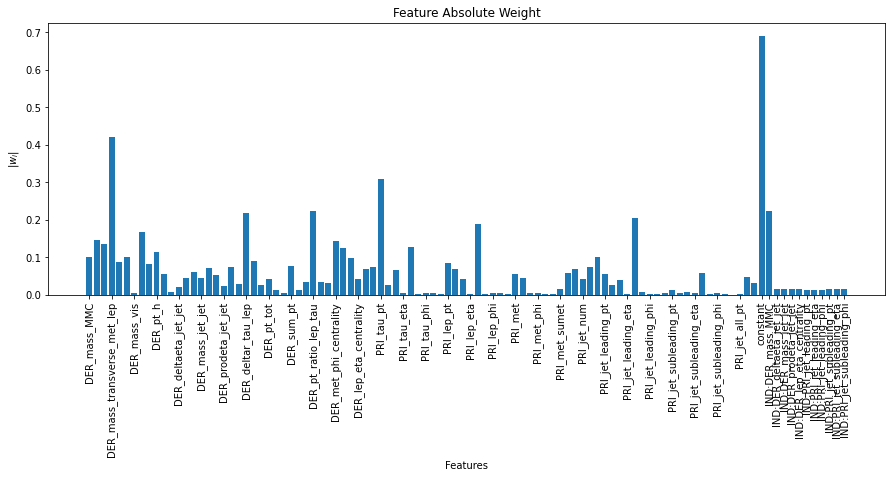

In [16]:
def feature_labels_full(df, nan_cols, degree):
    col_names = [col for col in df.drop(columns=['Id','Prediction'])]
    nan_labels = [f'IND:{col}' for col in train.drop(columns=['Id','Prediction']).iloc[:,nan_cols]]
    
    poly_labels = []
    for name in col_names:
        for d in range(1,degree+1):
            poly_labels.append(f'{name}^{d}')
    
    labels = poly_labels + ['constant'] + nan_labels
    idx = np.arange(len(labels)) 
    
    return idx, labels

def feature_labels_sparse(df, nan_cols, degree):  
    col_names = [col for col in df.drop(columns=['Id','Prediction'])]
    nan_labels = [f'IND:{col}' for col in train.drop(columns=['Id','Prediction']).iloc[:,nan_cols]]
    
    labels = col_names + ['constant'] + nan_labels
    
    idx = np.arange(len(labels)) 
    idx[:len(col_names)+1] *= degree
    idx[len(col_names)+1:] += idx[len(col_names)] - idx[len(col_names)+1] + 1
    
    return idx, labels

# Plot feature weights
fig = plt.figure(figsize=(15,5))
plt.bar(np.arange(w.shape[0]), abs(w))

idx, labels = feature_labels_sparse(train, nan_cols, degree)
plt.xticks(idx, labels, rotation=90)
plt.xlabel('Features')
plt.ylabel('$|w_i|$')
plt.title('Feature Absolute Weight');

In [17]:
idx, labels = feature_labels_full(train, nan_cols, degree)
perm = np.argsort(-abs(w))
w_norm = abs(w) / np.linalg.norm(w)
for i in range(w.shape[0]):
    print(f'{labels[perm[i]]:30s} = {abs(w[perm[i]]):.4e}  ({w_norm[perm[i]]:.4f})')

constant                       = 6.9105e-01  (0.6132)
DER_mass_transverse_met_lep^1  = 4.2015e-01  (0.3728)
PRI_tau_pt^1                   = 3.0975e-01  (0.2749)
DER_pt_ratio_lep_tau^1         = 2.2331e-01  (0.1982)
IND:DER_mass_MMC               = 2.2246e-01  (0.1974)
DER_deltar_tau_lep^1           = 2.1879e-01  (0.1941)
PRI_jet_leading_eta^2          = 2.0377e-01  (0.1808)
PRI_lep_eta^2                  = 1.8738e-01  (0.1663)
DER_mass_vis^2                 = 1.6806e-01  (0.1491)
DER_mass_MMC^2                 = 1.4492e-01  (0.1286)
DER_met_phi_centrality^1       = 1.4303e-01  (0.1269)
DER_mass_MMC^3                 = 1.3376e-01  (0.1187)
PRI_tau_eta^2                  = 1.2627e-01  (0.1120)
DER_met_phi_centrality^2       = 1.2443e-01  (0.1104)
DER_pt_h^1                     = 1.1301e-01  (0.1003)
DER_mass_transverse_met_lep^3  = 1.0015e-01  (0.0889)
PRI_jet_num^3                  = 9.9744e-02  (0.0885)
DER_mass_MMC^1                 = 9.9439e-02  (0.0882)
DER_met_phi_centrality^3    

## Generate submission



In [18]:
from helpers import create_csv_submission
import importlib

ids = test['Id']
y_pred = np.rint(sigmoid(tx_te @ w))
y_pred[y_pred == 0] = -1
y_pred[y_pred == 1] = 1

create_csv_submission(ids, y_pred, '../submission.csv')

## Notes



## It seems that adding the missing value indicators makes the method more "consitent with expectation". That is, the test loss and accuracy now follow similar patterns (both go up/down together). Without them, the highest accuracy tended to be where the test loss "blew up" (inf or nan).

